First set up the correct paths pointing to the directories containing the images, bounding boxes and instances.

In [4]:
# Settings
kitti_img_dir = "<path>/data_object_image_2/training/image_2"
kitti_box_dir = "<path>/data_object_label_2/training/label_2"
kitti_inst_dir = "<path>/data_object_instance_2/training/instance_2"

In [2]:
# Imports
import colorsys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io as io

In [3]:
# Function definitions

HSV_mapping = {
#  ID:  [ H_min, H_max,    S,   v ]
    0:  [  0.00,  1.00, 0.00, 0.0 ], # Background
    1:  [  0.00,  1.00, 1.00, 0.9 ], # Vehicle linked to box
    2:  [  0.00,  1.00, 1.00, 0.9 ], # Pedestrian linked to box
    3:  [  0.00,  1.00, 0.40, 0.6 ], # Vehicle or Pedestrian without box 
}


def load_boxes(path):
    """Load KITTI3D bounding boxes.
    
    Args:
        path (str): Absolute path to object annotation txt file.
        
    Returns:
        boxes (DataFrame): Pandas DataFrame containing object annotations.
    """
    return pd.read_csv(
        path,
        sep=" ",
        names=('type',    'truncation',  'occlusion',  'alpha',   'left',  'top',   'right',  'bottom',
               'height',  'width',       'length',     'x',       'y',     'z',     'ry',     'tid' )
    )


def draw_boxes(img, boxes):
    """Draw 2d object boxes on top of image for visualisation.
    
    Args:
        img (np.array): Image to draw on.
        boxes (DataFrame): Pandas DataFrame containing object annotations.
        
    Returns:
        img (np.array): Image with drawn objects.
    """
    class_map = {
        'Car': 1,
        'Truck': 1,
        'Van': 1,
        'Pedestrian': 2,
        'Person_sitting': 2,
        'Cyclist': 0,
        'DontCare': 0,
        'Misc': 0,
        'Tram': 0
    }
    for i in range(len(boxes)):
        obj_class = class_map[boxes['type'][i]]
        if obj_class==0: continue
        hue_min, hue_max, saturation, value = HSV_mapping[obj_class]
        color = get_rgb_from_id(int(i), hue_min, hue_max, saturation=saturation, value=value)
        cv2.rectangle(
            img=img, 
            pt1=(int(boxes['left'][i]), int(boxes['top'][i])),
            pt2=(int(boxes['right'][i]), int(boxes['bottom'][i])), 
            color=color*255,
            thickness=2
        )
    return img


def map_instance_to_color(instances, HSV_mapping=HSV_mapping):
    """Map instances to the corresponding colors.

    Args:
        instances (np.array): Instance array. [ H x W ]
        HSV_mapping (dict, optional): Dictionary containing for every instance class a list with [hue_min, hue_max, saturation, value].

    Returns:
        np.array: Array containing the color coded instances [ H x W x 3]
    """
    assert isinstance(instances, np.ndarray), f"'instances' must be of type np.array, not {type(instances)}"
    # Get unique instances
    uniques, instance_map = np.unique(instances, return_inverse=True)
    # Make color_map
    color_map = []
    for instance_id in uniques:
        # Determine color range
        segm_class = instance_id//1000
        box_id = instance_id%1000
        hue_min, hue_max, saturation, value = HSV_mapping.get(segm_class, [0, 1, 1, 1])
        # Get color for each instance
        color_map.append(get_rgb_from_id(int(box_id), hue_min, hue_max, saturation=saturation, value=value))
    color_map = np.array(color_map)
    # Create colored instance image
    instance_map = color_map[instance_map.reshape(instances.shape)]
    return instance_map


def get_rgb_from_id(instance_id, hue_min=0, hue_max=1, saturation=0.9, value=0.9):
    """Map an instance/bbox id to a unique color.

    Args:
        instance_id (int): Value representing a unique id.
        hue_min (float, optional): Minimum value for the hue range in which this id should be mapped. Should be greater than or equal to 0. Default: 0
        hue_max (float, optional): Maximum value for the hue range in which this id should be mapped. If larger than 1, hue value will loop back to 0. Default: 1
        saturation (float, optional): Value between 0 and 1 for saturation. Default: 0.9
        value (float, optional): Value between 0 and 1 for brightness. Default: 0.9

    Returns:
        np.array[(3,)]: Array containing the RGB values for this instance id, with values between 0 and 1.
    """
    assert isinstance(instance_id, (int, np.int32)), f"instance_id should be of type 'int', not '{type(instance_id)}'"
    assert isinstance(hue_min, (int, float)) and isinstance(hue_max, (int, float)), f"hue_min and hue_max should be of type 'float', not '{type(hue_min)}' and '{type(hue_max)}'"
    assert isinstance(saturation, (int, float)) and saturation >= 0 and saturation <= 1, f"saturation should be a float between 0 and 1, not '{saturation}'"
    assert isinstance(value, (int, float)) and value >= 0 and value <= 1, f"value should be a float between 0 and 1, not '{value}'"
    
    # Golden angle: equally distributed colors but as far appart as possible; Hue will be between 0 and 1
    golden_angle = 137/360
    h = (instance_id*golden_angle) % 1
    # Scale hue in range (hue_min, hue_max)
    h = h*(hue_max-hue_min) + hue_min
    # Get rgb values
    rgb = np.array(colorsys.hsv_to_rgb(h, saturation, value))
    return rgb


def plot_sample(i, kitti_img_dir, kitti_box_dir, kitti_inst_dir, alpha=0.6):
    """Visualise the instances and corresponding bounding boxes for a KITTI3D image.
    
    Args:
        i (int): Number of the image that needs to be shown.
        kitti_img_dir (str): Absolute path to the directory which contains the KITTI3D images.
        kitti_box_dir (str): Absolute path to the directory which contains the KITTI3D object annotations.
        kitti_inst_dir (str): Absolute path to the directory which contains our instance annotations.
    """
    # Get paths
    sample_name = f"{i:06d}"
    img_path = f"{kitti_img_dir}/{sample_name}.png"
    box_path = f"{kitti_box_dir}/{sample_name}.txt"
    inst_path = f"{kitti_inst_dir}/{sample_name}.png"

    # Load image, objects and instances
    img_inst = io.imread(img_path)
    img_box = img_inst.copy()
    boxes = load_boxes(box_path)
    inst = io.imread(inst_path)

    # Visualalise instances
    inst_color = map_instance_to_color(inst)
    mask = inst_color.sum(axis=2)
    img_inst[:] = img_inst[:]*0.5
    img_inst[mask!=0,:] = img_inst[mask!=0,:]*(1-alpha) + inst_color[mask!=0,:]*256*alpha
    # Visulaise boxes
    img_box = draw_boxes(img_box, boxes)
    
    # Create Figure
    plt.figure(figsize=(10,6))
    # Plot Instances
    ax1 = plt.subplot(2, 1, 1, frameon=False)
    ax1.imshow(img_inst)
    ax1.axis('off')
    plt.title(sample_name)
    # Plot Boxes
    ax2 = plt.subplot(2, 1, 2, frameon=False)
    ax2.imshow(img_box)
    ax2.axis('off')
    # Render
    plt.tight_layout()
    plt.show()

Instances which are matched to a bounding box annotation are shown in bright colors.
Instances without matches are shown in less saturated colors

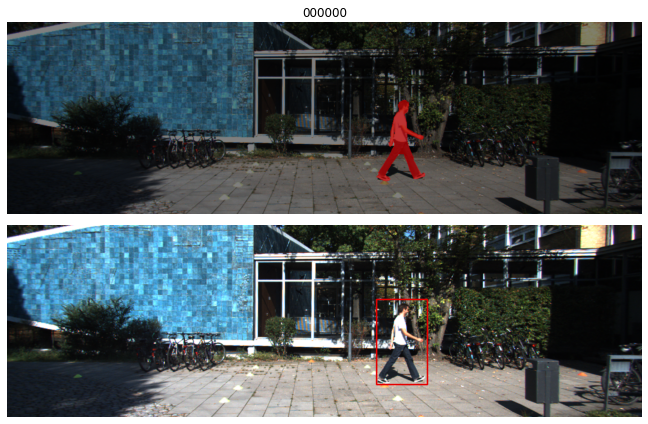

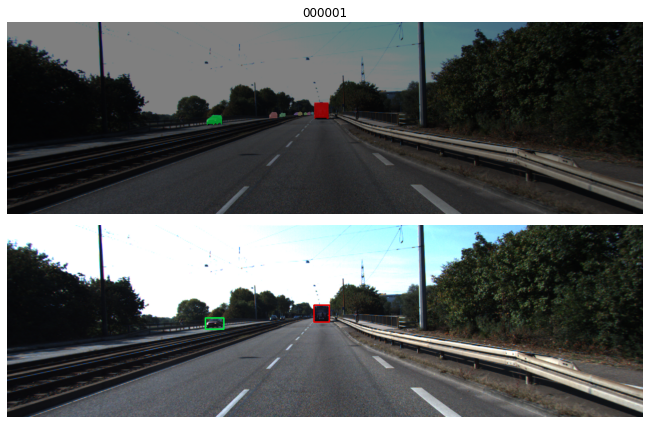

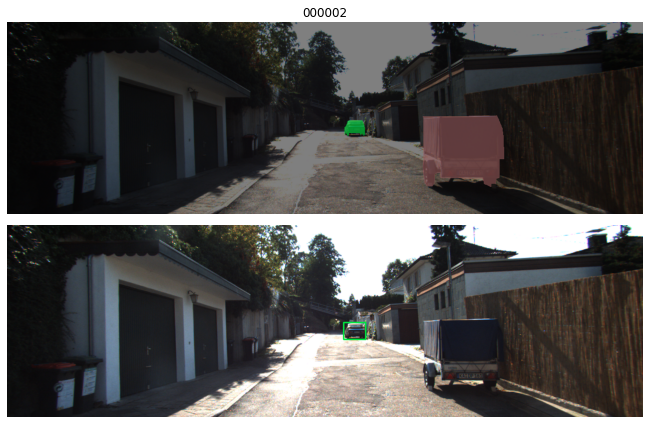

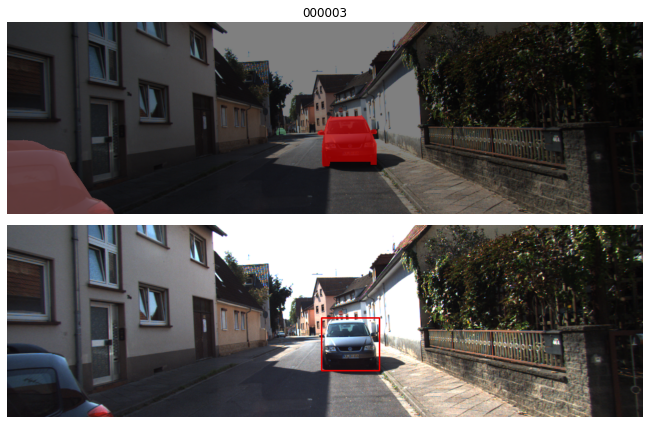

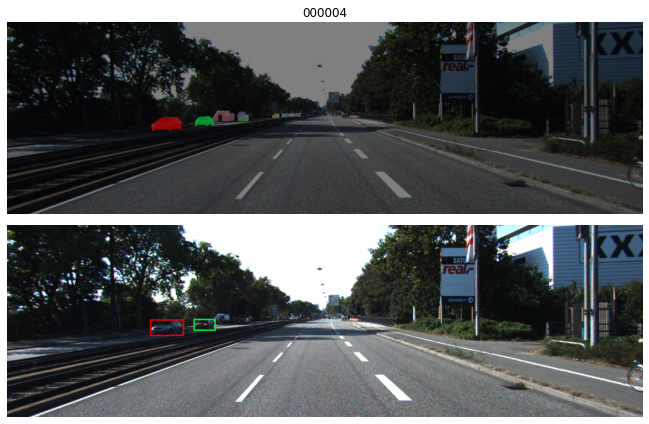

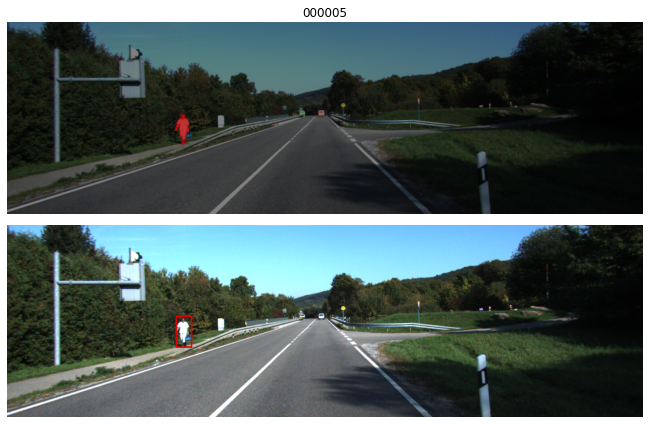

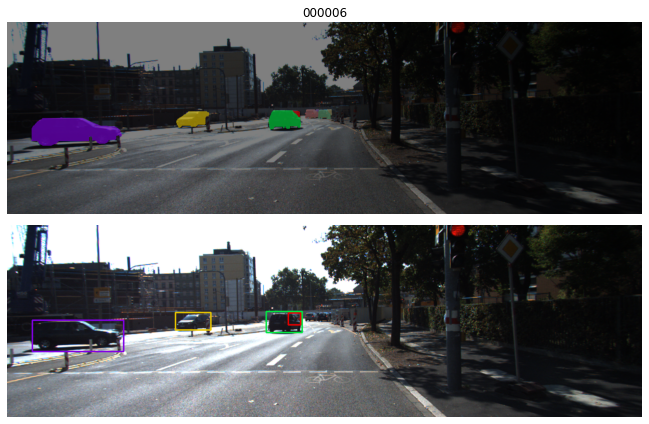

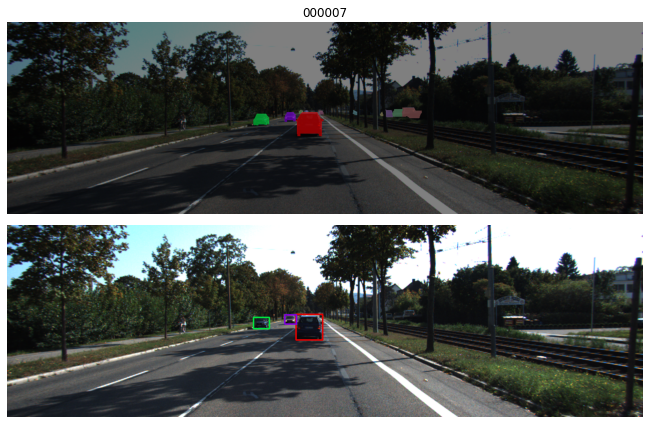

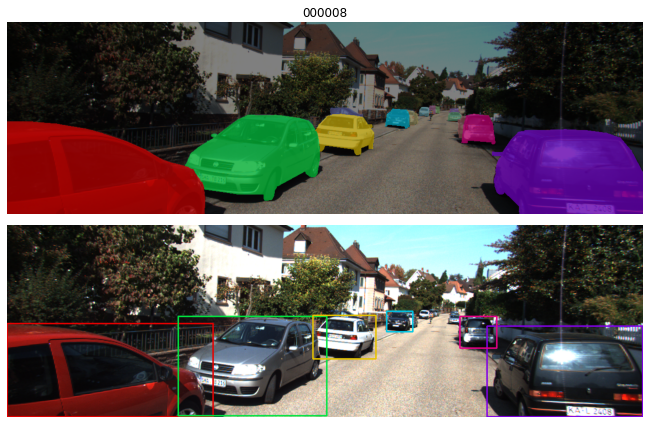

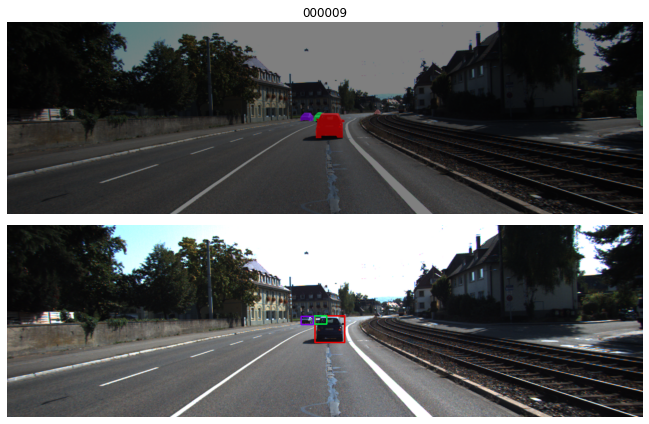

In [6]:
# Show first 10 images
for i in range(10):
    plot_sample(i, kitti_img_dir, kitti_box_dir, kitti_inst_dir)